<a href="https://colab.research.google.com/github/Yash-10/CAMELS-CNN-Interpretability-using-CKA/blob/main/CAMELS_CKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna==2.4.0

In [ ]:
import numpy as np
import optuna
from google.colab import drive
import torch
import torch.nn as nn
import sys,os

from torch.utils.data import DataLoader

For each field, comparison using two approaches is done:\
a. Between smoothed and not smoothed.\
b. Between different models (same architecture), both without smoothing.

Get the weights of the two models to compare and the corresponding database file(s).

In [ ]:
# Database by default needed for both experiments.
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/Nbody_o3_Mtot_all_steps_500_500_o3.db

# a. Smoothing and non-smoothed download.
# !wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_Nbody_Mtot_32_all_steps_500_500_o3_smoothing_2.pt
# !wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_Nbody_Mtot_32_all_steps_500_500_o3.pt
# !wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/Nbody_o3_Mtot_all_steps_500_500_o3_smoothing_2.db

# b. Between different models (same architecture), both without smoothing.
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_Nbody_Mtot_44_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_Nbody_Mtot_29_all_steps_500_500_o3.pt

--2023-05-10 12:58:14--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/Nbody_o3_Mtot_all_steps_500_500_o3.db
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60416 (59K) [application/octet-stream]
Saving to: ‘Nbody_o3_Mtot_all_steps_500_500_o3.db’

Nbody_o3_Mtot_all_s 100%[===================>]  59.00K  --.-KB/s    in 0.08s   

2023-05-10 12:58:14 (748 KB/s) - ‘Nbody_o3_Mtot_all_steps_500_500_o3.db’ saved [60416/60416]



In [ ]:
fweights_1   = '/content/weights_Nbody_Mtot_29_all_steps_500_500_o3.pt'
fweights_2   = '/content/weights_Nbody_Mtot_44_all_steps_500_500_o3.pt'
fdatabase1  = 'sqlite://///content/Nbody_o3_Mtot_all_steps_500_500_o3.db'
# fdatabase2  = 'sqlite://///content/Nbody_o3_Mtot_all_steps_500_500_o3_smoothing_2.db'
study_name = 'wd_dr_hidden_lr_o3'

trial_number_1 = int(fweights_1.split('/')[2].split('_')[3])
trial_number_2 = int(fweights_2.split('/')[2].split('_')[3])

In [ ]:
study = optuna.load_study(study_name=study_name, storage=fdatabase1)
for i in range(len(study.trials)-1):
  print(i, study.trials[i].params['hidden'])

0 12
1 6
2 12
3 10
4 12
5 7
6 6
7 9
8 6
9 6
10 8
11 6
12 6
13 10
14 12
15 6
16 12
17 10
18 11
19 12
20 9
21 9
22 8
23 8
24 8
25 8
26 7
27 7
28 11
29 11
30 11
31 11
32 11
33 9
34 10
35 10
36 10
37 11
38 11
39 9
40 9
41 7
42 12
43 12
44 12
45 8
46 8
47 11
48 11
49 12
50 12
51 10


In [ ]:
class model_o3_err(nn.Module):
    def __init__(self, hidden, dr, channels):
        super(model_o3_err, self).__init__()

        # input: 1x256x256 ---------------> output: 2*hiddenx128x128
        self.C01 = nn.Conv2d(channels,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C02 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C03 = nn.Conv2d(2*hidden,  2*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B01 = nn.BatchNorm2d(2*hidden)
        self.B02 = nn.BatchNorm2d(2*hidden)
        self.B03 = nn.BatchNorm2d(2*hidden)

        # input: 2*hiddenx128x128 ----------> output: 4*hiddenx64x64
        self.C11 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C12 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C13 = nn.Conv2d(4*hidden, 4*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B11 = nn.BatchNorm2d(4*hidden)
        self.B12 = nn.BatchNorm2d(4*hidden)
        self.B13 = nn.BatchNorm2d(4*hidden)

        # input: 4*hiddenx64x64 --------> output: 8*hiddenx32x32
        self.C21 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C22 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C23 = nn.Conv2d(8*hidden, 8*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B21 = nn.BatchNorm2d(8*hidden)
        self.B22 = nn.BatchNorm2d(8*hidden)
        self.B23 = nn.BatchNorm2d(8*hidden)

        # input: 8*hiddenx32x32 ----------> output: 16*hiddenx16x16
        self.C31 = nn.Conv2d(8*hidden,  16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C32 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C33 = nn.Conv2d(16*hidden, 16*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B31 = nn.BatchNorm2d(16*hidden)
        self.B32 = nn.BatchNorm2d(16*hidden)
        self.B33 = nn.BatchNorm2d(16*hidden)

        # input: 16*hiddenx16x16 ----------> output: 32*hiddenx8x8
        self.C41 = nn.Conv2d(16*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C42 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C43 = nn.Conv2d(32*hidden, 32*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B41 = nn.BatchNorm2d(32*hidden)
        self.B42 = nn.BatchNorm2d(32*hidden)
        self.B43 = nn.BatchNorm2d(32*hidden)

        # input: 32*hiddenx8x8 ----------> output:64*hiddenx4x4
        self.C51 = nn.Conv2d(32*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C52 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=3, stride=1, padding=1,
                            padding_mode='circular', bias=True)
        self.C53 = nn.Conv2d(64*hidden, 64*hidden, kernel_size=2, stride=2, padding=0,
                            padding_mode='circular', bias=True)
        self.B51 = nn.BatchNorm2d(64*hidden)
        self.B52 = nn.BatchNorm2d(64*hidden)
        self.B53 = nn.BatchNorm2d(64*hidden)

        # input: 64*hiddenx4x4 ----------> output: 128*hiddenx1x1
        self.C61 = nn.Conv2d(64*hidden, 128*hidden, kernel_size=4, stride=1, padding=0,
                            padding_mode='circular', bias=True)
        self.B61 = nn.BatchNorm2d(128*hidden)

        self.P0  = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

        self.FC1  = nn.Linear(128*hidden, 64*hidden)
        self.FC2  = nn.Linear(64*hidden,  12)

        self.dropout   = nn.Dropout(p=dr)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):
        x01 = self.C01(image)
        x01_ = self.LeakyReLU(x01)
        x02 = self.C02(x01_)
        x02_ = self.LeakyReLU(self.B02(x02))
        x03 = self.C03(x02_)
        x03_ = self.LeakyReLU(self.B03(x03))

        x11 = self.C11(x03_)
        x11_ = self.LeakyReLU(self.B11(x11))
        x12 = self.C12(x11_)
        x12_ = self.LeakyReLU(self.B12(x12))
        x13 = self.C13(x12_)
        x13_ = self.LeakyReLU(self.B13(x13))

        x21 = self.C21(x13_)
        x21_ = self.LeakyReLU(self.B21(x21))
        x22 = self.C22(x21_)
        x22_ = self.LeakyReLU(self.B22(x22))
        x23 = self.C23(x22_)
        x23_ = self.LeakyReLU(self.B23(x23))

        x31 = self.C31(x23_)
        x31_ = self.LeakyReLU(self.B31(x31))
        x32 = self.C32(x31_)
        x32_ = self.LeakyReLU(self.B32(x32))
        x33 = self.C33(x32_)
        x33_ = self.LeakyReLU(self.B33(x33))

        x41 = self.C41(x33_)
        x41_ = self.LeakyReLU(self.B41(x41))
        x42 = self.C42(x41_)
        x42_ = self.LeakyReLU(self.B42(x42))
        x43 = self.C43(x42_)
        x43_ = self.LeakyReLU(self.B43(x43))

        x51 = self.C51(x43_)
        x51_ = self.LeakyReLU(self.B51(x51))
        x52 = self.C52(x51_)
        x52_ = self.LeakyReLU(self.B52(x52))
        x53 = self.C53(x52_)
        x53_ = self.LeakyReLU(self.B53(x53))

        x61 = self.C61(x53_)
        x61_ = self.LeakyReLU(self.B61(x61))

        x61__ = x61_.view(image.shape[0],-1)
        x61__ = self.dropout(x61__)

        x71 = self.FC1(x61__)
        x71_ = self.LeakyReLU(x71)
        x71__ = self.dropout(x71_)
        x81 = self.FC2(x71__)

        # enforce the errors to be positive
        y = torch.clone(x81)
        y[:,6:12] = torch.square(x81[:,6:12])

        return y, [x01_, x02_, x03_, x11_, x12_, x13_, x21_, x22_, x23_, x31_, x32_, x33_, x41_, x42_, x43_, x51_, x52_, x53_, x61_, x71_, x81]

def load_two_models_for_similarity_measure(fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None):
  if fdatabase2 is None:
    print('Assuming same database for the two models...')

  if torch.cuda.is_available():
    print("GPUs available")
    device = torch.device('cuda')
  else:
    print('GPUs not available')
    device = torch.device('cpu')

  fweights = [fweights_1, fweights_2]
  fdatabases = [fdatabase1, fdatabase2]
  trial_numbers = [trial_number_1, trial_number_2]
  models = []

  for i in range(2):
    if fdatabase2 is None:
      study = optuna.load_study(study_name=study_name, storage=fdatabase1)
    else:
      study = optuna.load_study(study_name=study_name, storage=fdatabases[i])

    print(f"\nTrial number: {trial_numbers[i]}")
    trial_number = trial_numbers[i]
    trial = study.trials[trial_number]
    print("Trial number:  number {}".format(trial.number))
    print("Loss:          %.5e"%trial.value)
    print("Params: ")
    for key, value in trial.params.items():
      print("    {}: {}".format(key, value))

    model = model_o3_err(trial.params['hidden'], trial.params['dr'], 1)
    model = nn.DataParallel(model)
    model.to(device=device)
    network_total_params = sum(p.numel() for p in model.parameters())
    print('total number of parameters in the model = %d'%network_total_params)

    if os.path.exists(fweights[i]):
      model.load_state_dict(torch.load(fweights[i], map_location=torch.device(device)))
      print('Weights loaded')
      models.append(model)
    else:
      raise Exception('file with weights not found!!!')

  if len(models) != 2:
    print("Warning! Two models were not loaded...")
  return models

In [ ]:
models = load_two_models_for_similarity_measure(
    fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None
)

Assuming same database for the two models...
GPUs not available

Trial number: 29
Trial number:  number 29
Loss:          -2.16248e+01
Params: 
    dr: 0.004468805436150754
    hidden: 11
    lr: 0.002648072745767048
    wd: 6.181939363914276e-05
total number of parameters in the model = 28436376
Weights loaded

Trial number: 44
Trial number:  number 44
Loss:          -2.15107e+01
Params: 
    dr: 0.008532125458895722
    hidden: 12
    lr: 0.004522825230895613
    wd: 0.0004250180264031109
total number of parameters in the model = 33839052
Weights loaded


# My ATTEMPT

TODO:

- Use best trial for NBody and Temperature when comparing them.
- Try to apply on weights directly. That way we don't depend on the amount and type of dataset used.
- Try running NBody vs Temp experiment again after normalizing features using mean and std. Code needs a fix.
- **Important**: Change the code so that it not does on only one batch, but a much larger set of test examples.
- Note that the medium article tells activations must be from same data: https://towardsdatascience.com/do-different-neural-networks-learn-the-same-things-ac215f2103c3
  - Maybe that's why we don't see good results with temp-nbody?

- **Important**: when comparing Nbody-Nbody or HI-HI, etc, select from the top-5 trials only, to be on the safer side. Also do this when comparing NBody-HI, etc.

In [ ]:
# !wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_IllustrisTNG.txt
!cp /content/drive/MyDrive/CAMELS/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy .

--2023-05-10 12:50:35--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_IllustrisTNG.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_Nbody_IllustrisTNG.txt’

params_Nbody_Illust 100%[===================>]  46.88K  --.-KB/s    in 0.08s   

2023-05-10 12:50:36 (606 KB/s) - ‘params_Nbody_IllustrisTNG.txt’ saved [48000/48000]



In [ ]:
# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


# This class creates the dataset. Rotations and flippings are precompued and stored in memory
class make_dataset_multifield():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize the value of the cosmological & astrophysical parameters
        minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        # define the matrix containing the maps with rotations and flipings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This class creates the dataset. It will read the maps and store them in memory.
# The rotations and flipings are done when calling the data
class make_dataset_multifield2():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of simulations and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]

        # normalize params
        minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)

        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]


# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_Nbody_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
4.957e+09 < F(all|orig) < 2.880e+15
9.695 < F(all|resc)  < 15.459
-2.795 < F(all|norm) < 8.860


In [ ]:
import tqdm
import numpy as np

In [ ]:
def unbiased_HSIC(K, L):
  '''Computes an unbiased estimator of HISC. This is equation (2) from the paper'''

  #create the unit **vector** filled with ones
  n = K.shape[0]
  ones = np.ones(shape=(n))

  #fill the diagonal entries with zeros
  np.fill_diagonal(K, val=0) #this is now K_tilde
  np.fill_diagonal(L, val=0) #this is now L_tilde

  #first part in the square brackets
  trace = np.trace(np.dot(K, L))

  #middle part in the square brackets
  nominator1 = np.dot(np.dot(ones.T, K), ones)
  nominator2 = np.dot(np.dot(ones.T, L), ones)
  denominator = (n-1)*(n-2)
  middle = np.dot(nominator1, nominator2) / denominator


  #third part in the square brackets
  multiplier1 = 2/(n-2)
  multiplier2 = np.dot(np.dot(ones.T, K), np.dot(L, ones))
  last = multiplier1 * multiplier2

  #complete equation
  unbiased_hsic = 1/(n*(n-3)) * (trace + middle - last)

  return unbiased_hsic

def CKA(X, Y):
  '''Computes the CKA of two matrices. This is equation (1) from the paper'''

  nominator = unbiased_HSIC(np.dot(X, X.T), np.dot(Y, Y.T))
  denominator1 = unbiased_HSIC(np.dot(X, X.T), np.dot(X, X.T))
  denominator2 = unbiased_HSIC(np.dot(Y, Y.T), np.dot(Y, Y.T))

  cka = nominator/np.sqrt(denominator1*denominator2)

  return cka

def calculate_CKA_for_two_matrices(activationA, activationB):
  '''Takes two activations A and B and computes the linear CKA to measure their similarity'''

  #unfold the activations, that is make a (n, h*w*c) representation
  shape = activationA.shape
  activationA = np.reshape(activationA, newshape=(shape[0], np.prod(shape[1:])))

  shape = activationB.shape
  activationB = np.reshape(activationB, newshape=(shape[0], np.prod(shape[1:])))

  #calculate the CKA score
  cka_score = CKA(activationA, activationB)

  del activationA
  del activationB

  return cka_score


# def get_all_layer_outputs_fn(model):
#   '''Builds and returns function that returns the output of every (intermediate) layer'''

#   return tf.keras.backend.function([model.layers[0].input],
#                                   [l.output for l in model.layers[1:]])

def compare_activations(modelA, modelB, data_batch):
  '''
  Calculate a pairwise comparison of hidden representations and return a matrix
  '''

  _, intermediate_outputs_A = modelA(data_batch)
  _, intermediate_outputs_B = modelB(data_batch)

  #create a placeholder array
  result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))

  i = 0
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
    j = 0
    for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
      print(outputA.shape, outputB.shape)
      cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
      result_array[i, j] = cka_score
      j+=1
    i+= 1

  return result_array, intermediate_outputs_A

In [ ]:
with torch.no_grad():
  for i, (x, y) in enumerate(test_loader):
    _, intermediate_outputs_A = compare_activations(models[0], models[1], x)
    break

In [ ]:
data_batch = []
for i, (x, y) in enumerate(test_loader):
  data_batch.append(x)
  if i == 3:
    break
x = torch.vstack(data_batch)
print(x.shape)

with torch.no_grad():
  sim = compare_activations(models[0], models[1], x)

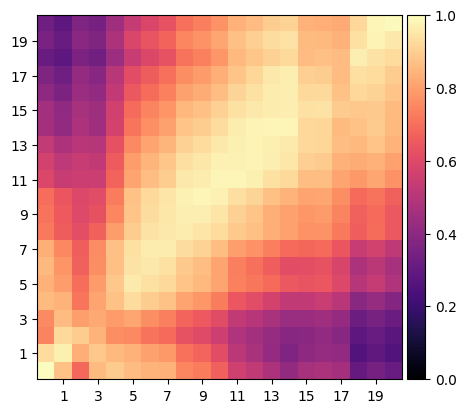

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
layers = np.arange(1, 21, 2)
ax.set_xticks(layers); ax.set_yticks(layers)
ax.set_xticklabels(layers); ax.set_yticklabels(layers)
ax.axes.invert_yaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.savefig("./r50_r152.png", dpi=400)

## For temperature maps

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/IllustrisTNG_o3_T_all_steps_500_500_o3.db
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_T_29_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_T_15_all_steps_500_500_o3.pt

--2023-05-10 12:58:44--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/IllustrisTNG_o3_T_all_steps_500_500_o3.db
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58368 (57K) [application/octet-stream]
Saving to: ‘IllustrisTNG_o3_T_all_steps_500_500_o3.db’

IllustrisTNG_o3_T_a 100%[===================>]  57.00K  --.-KB/s    in 0.08s   

2023-05-10 12:58:44 (749 KB/s) - ‘IllustrisTNG_o3_T_all_steps_500_500_o3.db’ saved [58368/58368]



In [ ]:
fweights_1   = '/content/weights_IllustrisTNG_T_9_all_steps_500_500_o3.pt'
fweights_2   = '/content/weights_IllustrisTNG_T_29_all_steps_500_500_o3.pt'
fdatabase1  = 'sqlite://///content/IllustrisTNG_o3_T_all_steps_500_500_o3.db'
# fdatabase2  = 'sqlite://///content/Nbody_o3_Mtot_all_steps_500_500_o3_smoothing_2.db'
study_name = 'wd_dr_hidden_lr_o3'

trial_number_1 = int(fweights_1.split('/')[2].split('_')[3])
trial_number_2 = int(fweights_2.split('/')[2].split('_')[3])

study = optuna.load_study(study_name=study_name, storage=fdatabase1)
for i in range(len(study.trials)-2):
  print(i, study.trials[i].params['hidden'])

In [ ]:
models = load_two_models_for_similarity_measure(
    fweights_1, fweights_2, fdatabase1, study_name, trial_number_1, trial_number_2, fdatabase2=None
)

Assuming same database for the two models...
GPUs not available

Trial number: 9
Trial number:  number 9
Loss:          -1.23800e+01
Params: 
    dr: 0.6739210638971285
    hidden: 9
    lr: 0.0010442548996156967
    wd: 1.53573354443088e-06
total number of parameters in the model = 19039800
Weights loaded

Trial number: 29
Trial number:  number 29
Loss:          -1.28350e+01
Params: 
    dr: 0.40298368418673847
    hidden: 11
    lr: 0.004576497146854049
    wd: 0.0005536111493029244
total number of parameters in the model = 28436376
Weights loaded


In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_IllustrisTNG.txt

--2023-05-08 11:56:58--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_IllustrisTNG.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_IllustrisTNG.txt’

params_IllustrisTNG 100%[===================>]  46.88K  --.-KB/s    in 0.08s   

2023-05-08 11:56:59 (616 KB/s) - ‘params_IllustrisTNG.txt’ saved [48000/48000]



In [ ]:
# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


# This class creates the dataset. Rotations and flippings are precompued and stored in memory
class make_dataset_multifield():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize the value of the cosmological & astrophysical parameters
        minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        # define the matrix containing the maps with rotations and flipings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This class creates the dataset. It will read the maps and store them in memory.
# The rotations and flipings are done when calling the data
class make_dataset_multifield2():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of simulations and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]

        # normalize params
        minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)

        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]


# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_T_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
1.547e+03 < F(all|orig) < 8.150e+07
3.189 < F(all|resc)  < 7.911
-1.267 < F(all|norm) < 4.517


In [ ]:
data_batch = []
for i, (x, y) in enumerate(test_loader):
  data_batch.append(x)
  if i == 3:
    break
x = torch.vstack(data_batch)
print(x.shape)

with torch.no_grad():
  sim = compare_activations(models[0], models[1], x)

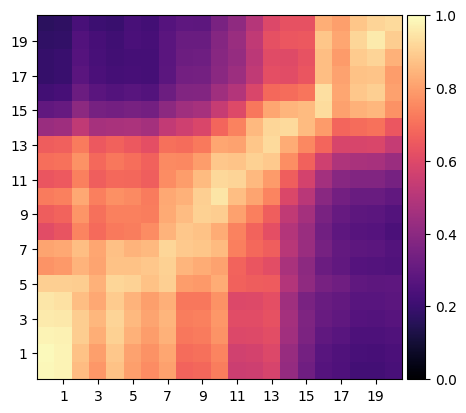

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
layers = np.arange(1, 21, 2)
ax.set_xticks(layers); ax.set_yticks(layers)
ax.set_xticklabels(layers); ax.set_yticklabels(layers)
ax.axes.invert_yaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.savefig("./r50_r152.png", dpi=400)

# For Heterogenous cases

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_29_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_15_all_steps_500_500_o3.pt

--2023-05-10 12:54:09--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_29_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135426256 (129M) [application/octet-stream]
Saving to: ‘weights_IllustrisTNG_HI_29_all_steps_500_500_o3.pt’

weights_IllustrisTN 100%[===================>] 129.15M  33.3MB/s    in 4.5s    

2023-05-10 12:54:14 (28.8 MB/s) - ‘weights_IllustrisTNG_HI_29_all_steps_500_500_o3.pt’ saved [135426256/135426256]

--2023-05-10 12:54:14--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_15_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)..

In [ ]:
fweights_1   = '/content/weights_Nbody_Mtot_44_all_steps_500_500_o3.pt'
fweights_2   = '/content/weights_IllustrisTNG_HI_15_all_steps_500_500_o3.pt'
fdatabase1  = 'sqlite://///content/Nbody_o3_Mtot_all_steps_500_500_o3.db'
fdatabase2  = 'sqlite://///content/IllustrisTNG_o3_HI_all_steps_500_500_o3.db'
study_name = 'wd_dr_hidden_lr_o3'

trial_number_1 = int(fweights_1.split('/')[2].split('_')[3])
trial_number_2 = int(fweights_2.split('/')[2].split('_')[3])

study1 = optuna.load_study(study_name=study_name, storage=fdatabase1)
study2 = optuna.load_study(study_name=study_name, storage=fdatabase2)

trial1 = study1.trials[trial_number_1]
trial2 = study2.trials[trial_number_2]

models = []

model = model_o3_err(trial1.params['hidden'], trial1.params['dr'], 1)
model = nn.DataParallel(model)
model.to(device=device)
model.load_state_dict(torch.load(fweights_1, map_location=torch.device(device)))
print('Weights loaded')
models.append(model)

model = model_o3_err(trial2.params['hidden'], trial2.params['dr'], 1)
model = nn.DataParallel(model)
model.to(device=device)
model.load_state_dict(torch.load(fweights_2, map_location=torch.device(device)))
print('Weights loaded')
models.append(model)

Weights loaded
Weights loaded


In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_IllustrisTNG_LH_z=0.00.npy

--2023-05-10 13:01:57--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_IllustrisTNG_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘Maps_HI_IllustrisTNG_LH_z=0.00.npy’

Maps_HI_IllustrisTN 100%[===================>]   3.66G  37.7MB/s    in 2m 12s  

2023-05-10 13:04:10 (28.4 MB/s) - ‘Maps_HI_IllustrisTNG_LH_z=0.00.npy’ saved [3932160128/3932160128]



In [ ]:
# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_Nbody_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

test_loader_nbody  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

# ========================================================
#data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_HI_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

test_loader_temp  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
4.957e+09 < F(all|orig) < 2.880e+15
9.695 < F(all|resc)  < 15.459
-2.795 < F(all|norm) < 8.860
Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
1.415e+01 < F(all|orig) < 2.656e+13
1.151 < F(all|resc)  < 13.424
-3.592 < F(all|norm) < 8.541


In [ ]:
import statistics
def compare_activations_heterogenous(modelA, modelB, data_batchA, data_batchB, normalize_outputs=False):
  '''
  Calculate a pairwise comparison of hidden representations and return a matrix
  '''

  _, intermediate_outputs_A = modelA(data_batchA)
  _, intermediate_outputs_B = modelB(data_batchB)

  if normalize_outputs:
    AA = torch.hstack([i.flatten() for i in intermediate_outputs_A])
    BB = torch.hstack([i.flatten() for i in intermediate_outputs_B])
    mean_A, std_A = AA.mean(), AA.std()
    mean_B, std_B = BB.mean(), BB.std()

    intermediate_outputs_A = [(i-mean_A) / std_A for i in intermediate_outputs_A]
    intermediate_outputs_B = [(i-mean_B) / std_B for i in intermediate_outputs_B]

    del AA, BB

    ########## Below code for normalizing in the range [0, 1] - results don't look good using this probably because of this, the values are changed quite a lot. ##########
    # AA = torch.hstack([i.flatten() for i in intermediate_outputs_A])
    # BB = torch.hstack([i.flatten() for i in intermediate_outputs_B])
    # min_A, max_A = AA.min(), AA.max()
    # min_B, max_B = BB.min(), BB.max()

    # intermediate_outputs_A = [(i-min_A) / (max_A - min_A) for i in intermediate_outputs_A]
    # intermediate_outputs_B = [(i-min_B) / (max_B - min_B) for i in intermediate_outputs_B]
    ####################################################################

  # #get function to get the output of every intermediate layer, for modelA and modelB
  # intermediate_outputs_A = get_all_layer_outputs_fn(modelA)(data_batch)
  # intermediate_outputs_B = get_all_layer_outputs_fn(modelB)(data_batch)

  #create a placeholder array
  result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))

  i = 0
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
    j = 0
    for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
      cka_score = calculate_CKA_for_two_matrices(outputA, outputB)
      result_array[i, j] = cka_score
      j+=1
    i+= 1

  return result_array, intermediate_outputs_A, intermediate_outputs_B

In [ ]:
import tqdm
import numpy as np

<ipython-input-27-546f06e65a57>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):


  0%|          | 0/21 [00:00<?, ?it/s]

<ipython-input-27-546f06e65a57>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

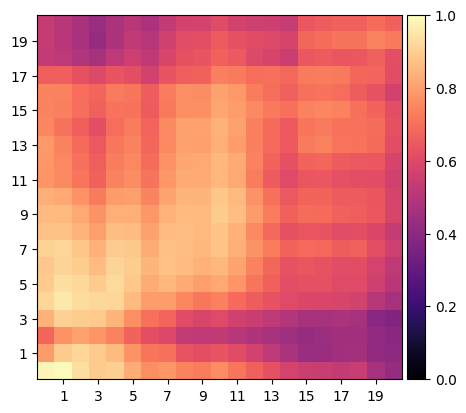

In [ ]:
loader_temp = iter(test_loader_temp)
x, y = next(loader_temp)

loader_nbody = iter(test_loader_nbody)
xn, yn = next(loader_nbody)

with torch.no_grad():
  sim, intermediate_outputs_A, intermediate_outputs_B = compare_activations_heterogenous(models[0], models[1], xn, xn, normalize_outputs=True)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
layers = np.arange(1, 21, 2)
ax.set_xticks(layers); ax.set_yticks(layers)
ax.set_xticklabels(layers); ax.set_yticklabels(layers)
ax.axes.invert_yaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.savefig("./r50_r152.png", dpi=400)

In [ ]:
for i in range(len(intermediate_outputs_A)):
  print(f'=== Layer {i+1} ===')
  print(f'Mean: {intermediate_outputs_A[i].mean(), intermediate_outputs_B[i].mean()}')
  print(f'Std: {intermediate_outputs_A[i].std(), intermediate_outputs_B[i].std()}')

# TNG - SIMBA

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_SIMBA_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_SIMBA_LH_z=0.00.npy

--2023-05-10 13:54:23--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy’

Maps_Mtot_Nbody_SIM 100%[===================>]   3.66G  37.9MB/s    in 2m 0s   

2023-05-10 13:56:24 (31.3 MB/s) - ‘Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy’ saved [3932160128/3932160128]

--2023-05-10 13:56:24--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_SIMBA_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.

In [ ]:
# !wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_SIMBA.txt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_SIMBA.txt

--2023-05-10 14:02:59--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_SIMBA.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_Nbody_SIMBA.txt’

params_Nbody_SIMBA. 100%[===================>]  46.88K  --.-KB/s    in 0.08s   

2023-05-10 14:03:00 (614 KB/s) - ‘params_Nbody_SIMBA.txt’ saved [48000/48000]



In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_HI_15_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_T_15_all_steps_500_500_o3.pt

--2023-05-10 14:49:16--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_HI_15_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113811512 (109M) [application/octet-stream]
Saving to: ‘weights_SIMBA_HI_15_all_steps_500_500_o3.pt’

weights_SIMBA_HI_15 100%[===================>] 108.54M  33.5MB/s    in 3.7s    

2023-05-10 14:49:20 (29.6 MB/s) - ‘weights_SIMBA_HI_15_all_steps_500_500_o3.pt’ saved [113811512/113811512]

--2023-05-10 14:49:20--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_SIMBA_T_15_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to 

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/SIMBA_o3_HI_all_steps_500_500_o3.db
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/SIMBA_o3_T_all_steps_500_500_o3.db

--2023-05-10 14:50:11--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/SIMBA_o3_HI_all_steps_500_500_o3.db
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58368 (57K) [application/octet-stream]
Saving to: ‘SIMBA_o3_HI_all_steps_500_500_o3.db’

SIMBA_o3_HI_all_ste 100%[===================>]  57.00K  --.-KB/s    in 0.08s   

2023-05-10 14:50:11 (747 KB/s) - ‘SIMBA_o3_HI_all_steps_500_500_o3.db’ saved [58368/58368]

--2023-05-10 14:50:11--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/SIMBA_o3_T_all_steps_500_500_o3.db
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatiro

In [ ]:
fweights_1   = '/content/weights_IllustrisTNG_HI_15_all_steps_500_500_o3.pt'
fweights_2   = '/content/weights_SIMBA_HI_15_all_steps_500_500_o3.pt'
fdatabase1  = 'sqlite://///content/IllustrisTNG_o3_HI_all_steps_500_500_o3.db'
fdatabase2  = 'sqlite://///content/SIMBA_o3_HI_all_steps_500_500_o3.db'
study_name = 'wd_dr_hidden_lr_o3'

trial_number_1 = int(fweights_1.split('/')[2].split('_')[3])
trial_number_2 = int(fweights_2.split('/')[2].split('_')[3])

study1 = optuna.load_study(study_name=study_name, storage=fdatabase1)
study2 = optuna.load_study(study_name=study_name, storage=fdatabase2)

trial1 = study1.trials[trial_number_1]
trial2 = study2.trials[trial_number_2]

models = []

model = model_o3_err(trial1.params['hidden'], trial1.params['dr'], 1)
model = nn.DataParallel(model)
model.to(device=device)
model.load_state_dict(torch.load(fweights_1, map_location=torch.device(device)))
print('Weights loaded')
models.append(model)

model = model_o3_err(trial2.params['hidden'], trial2.params['dr'], 1)
model = nn.DataParallel(model)
model.to(device=device)
model.load_state_dict(torch.load(fweights_2, map_location=torch.device(device)))
print('Weights loaded')
models.append(model)


# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_HI_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

test_loader_nbody  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

# ========================================================
#data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_HI_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

test_loader_temp  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

Weights loaded
Weights loaded
Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
1.415e+01 < F(all|orig) < 2.656e+13
1.151 < F(all|resc)  < 13.424
-3.592 < F(all|norm) < 8.541
Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
1.415e+01 < F(all|orig) < 2.656e+13
1.151 < F(all|resc)  < 13.424
-3.592 < F(all|norm) < 8.541


<ipython-input-27-546f06e65a57>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):


  0%|          | 0/21 [00:00<?, ?it/s]

<ipython-input-27-546f06e65a57>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

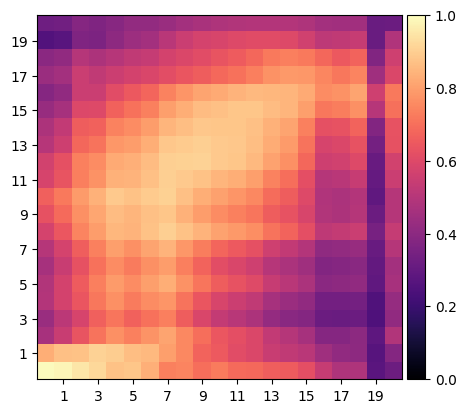

In [ ]:
loader_temp = iter(test_loader_temp)
x, y = next(loader_temp)

loader_nbody = iter(test_loader_nbody)
xn, yn = next(loader_nbody)

with torch.no_grad():
  sim, intermediate_outputs_A, intermediate_outputs_B = compare_activations_heterogenous(models[0], models[1], xn, xn, normalize_outputs=True)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
layers = np.arange(1, 21, 2)
ax.set_xticks(layers); ax.set_yticks(layers)
ax.set_xticklabels(layers); ax.set_yticklabels(layers)
ax.axes.invert_yaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.savefig("./r50_r152.png", dpi=400)

# NBody-HI

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_30_all_steps_500_500_o3.pt

--2023-05-09 16:32:25--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_30_all_steps_500_500_o3.pt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135426270 (129M) [application/octet-stream]
Saving to: ‘weights_IllustrisTNG_HI_30_all_steps_500_500_o3.pt’

weights_IllustrisTN 100%[===================>] 129.15M  64.2MB/s    in 2.0s    

2023-05-09 16:32:27 (64.2 MB/s) - ‘weights_IllustrisTNG_HI_30_all_steps_500_500_o3.pt’ saved [135426270/135426270]



In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/weights/weights_IllustrisTNG_HI_44_all_steps_500_500_o3.pt
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/inference/databases/IllustrisTNG_o3_HI_all_steps_500_500_o3.db

In [ ]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [ ]:
fweights_1   = '/content/weights_Nbody_Mtot_44_all_steps_500_500_o3.pt'
fweights_2   = '/content/weights_IllustrisTNG_HI_30_all_steps_500_500_o3.pt'
fdatabase1  = 'sqlite://///content/Nbody_o3_Mtot_all_steps_500_500_o3.db'
fdatabase2  = 'sqlite://///content/IllustrisTNG_o3_HI_all_steps_500_500_o3.db'
study_name = 'wd_dr_hidden_lr_o3'

trial_number_1 = int(fweights_1.split('/')[2].split('_')[3])
trial_number_2 = int(fweights_2.split('/')[2].split('_')[3])

study1 = optuna.load_study(study_name=study_name, storage=fdatabase1)
study2 = optuna.load_study(study_name=study_name, storage=fdatabase2)

trial1 = study1.trials[trial_number_1]
trial2 = study2.trials[trial_number_2]

models = []

model = model_o3_err(trial1.params['hidden'], trial1.params['dr'], 1)
model = nn.DataParallel(model)
model.to(device=device)
model.load_state_dict(torch.load(fweights_1, map_location=torch.device(device)))
print('Weights loaded')
models.append(model)

model = model_o3_err(trial2.params['hidden'], trial2.params['dr'], 1)
model = nn.DataParallel(model)
model.to(device=device)
model.load_state_dict(torch.load(fweights_2, map_location=torch.device(device)))
print('Weights loaded')
models.append(model)

Weights loaded
Weights loaded


In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_IllustrisTNG_LH_z=0.00.npy

--2023-05-09 14:17:33--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_HI_IllustrisTNG_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘Maps_HI_IllustrisTNG_LH_z=0.00.npy’

Maps_HI_IllustrisTN 100%[===================>]   3.66G  85.9MB/s    in 44s     

2023-05-09 14:18:17 (85.8 MB/s) - ‘Maps_HI_IllustrisTNG_LH_z=0.00.npy’ saved [3932160128/3932160128]



In [ ]:
# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_Nbody_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

test_loader_nbody  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

# ========================================================
# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

fmaps2 = '/content/Maps_HI_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

test_loader_hi  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
4.957e+09 < F(all|orig) < 2.880e+15
9.695 < F(all|resc)  < 15.459
-2.795 < F(all|norm) < 8.860
Shape of the maps: (15000, 256, 256)
Selected 5000 maps out of 15000
CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
1.415e+01 < F(all|orig) < 2.656e+13
1.151 < F(all|resc)  < 13.424
-3.592 < F(all|norm) < 8.541


<ipython-input-11-546f06e65a57>:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):


  0%|          | 0/21 [00:00<?, ?it/s]

<ipython-input-11-546f06e65a57>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

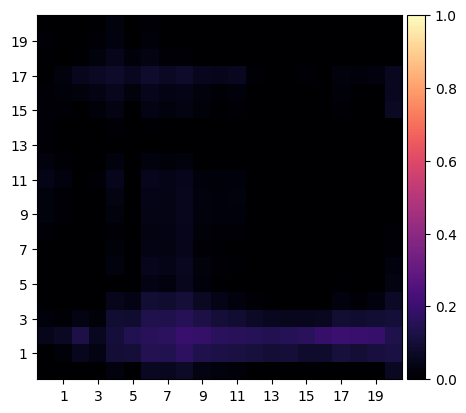

In [ ]:
loader_temp = iter(test_loader_hi)
x, y = next(loader_temp)

loader_nbody = iter(test_loader_nbody)
xn, yn = next(loader_nbody)

with torch.no_grad():
  sim, intermediate_outputs_A, intermediate_outputs_B = compare_activations_heterogenous(models[0], models[1], xn, x, normalize_outputs=True)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(sim, cmap='magma', vmin=0.0,vmax=1.0)
layers = np.arange(1, 21, 2)
ax.set_xticks(layers); ax.set_yticks(layers)
ax.set_xticklabels(layers); ax.set_yticklabels(layers)
ax.axes.invert_yaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.savefig("./r50_r152.png", dpi=400)

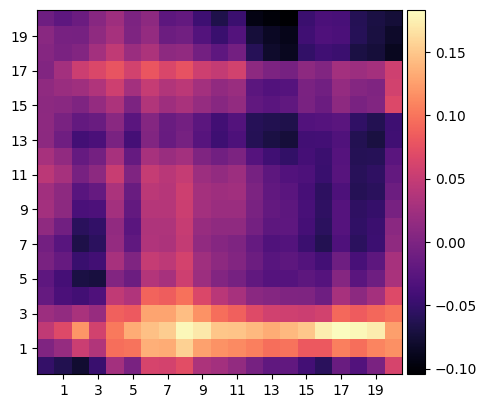

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(np.log(1+sim), cmap='magma')
layers = np.arange(1, 21, 2)
ax.set_xticks(layers); ax.set_yticks(layers)
ax.set_xticklabels(layers); ax.set_yticklabels(layers)
ax.axes.invert_yaxis()
fig.colorbar(im, cax=cax, orientation='vertical')
# plt.savefig("./r50_r152.png", dpi=400)

# y-axis is nbody and x-axis is HI.

Trying directly on weights

In [ ]:
with torch.no_grad():
  for m0 in models[0].module.named_children():
    if isinstance(m0[1], nn.Conv2d) or isinstance(m0[1], nn.Linear):
      print(m0[1].weight.numpy().shape)

(22, 1, 3, 3)
(22, 22, 3, 3)
(22, 22, 2, 2)
(44, 22, 3, 3)
(44, 44, 3, 3)
(44, 44, 2, 2)
(88, 44, 3, 3)
(88, 88, 3, 3)
(88, 88, 2, 2)
(176, 88, 3, 3)
(176, 176, 3, 3)
(176, 176, 2, 2)
(352, 176, 3, 3)
(352, 352, 3, 3)
(352, 352, 2, 2)
(704, 352, 3, 3)
(704, 704, 3, 3)
(704, 704, 2, 2)
(1408, 704, 4, 4)
(704, 1408)
(12, 704)


In [ ]:
from torchsummary import summary
summary(models[0].module, (1, 256, 256))

RuntimeError: ignored

In [ ]:
def compare_activations2(intermediate_outputs_A, intermediate_outputs_B):
  #create a placeholder array
  result_array = np.zeros(shape=(len(intermediate_outputs_A), len(intermediate_outputs_B)))

  i = 0
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
    j = 0
    for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
      oA = np.expand_dims(outputA, 0)
      oB = np.expand_dims(outputB, 0)
      # print(oA.shape, oB.shape)
      oA = np.repeat(oA, repeats=16, axis=0)
      oB = np.repeat(oB, repeats=16, axis=0)
      cka_score = calculate_CKA_for_two_matrices(oA, oB)
      result_array[i, j] = cka_score
      j+=1
    i+= 1

  return result_array, intermediate_outputs_A, intermediate_outputs_B

  ##################  My attempt #########################################
  # i = 0
  # for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):
  #   j = 0
  #   for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):
  #     if outputA.ndim == 2:
  #       outputA_ = outputA.mean(axis=(1))
  #     if outputB.ndim == 2:
  #       outputB_ = outputB.mean(axis=(1))
  #     if outputA.ndim == 4:
  #       outputA_ = outputA.mean(axis=(1,2,3))
  #     if outputB.ndim == 4:
  #       outputB_ = outputB.mean(axis=(1,2,3))
  #     outputA_ = np.expand_dims(outputA_, 0)
  #     outputB_ = np.expand_dims(outputB_, 0)
  #     print(outputA_.shape, outputB_.shape)
  #     cka_score = calculate_CKA_for_two_matrices(outputA_, outputB_)
  #     result_array[i, j] = cka_score
  #     j+=1
  #   i+= 1

  # return result_array
  ###########################################################################

m0_weights = []
m1_weights = []
with torch.no_grad():
  for m0, m1 in zip(models[0].module.named_children(), models[1].module.named_children()):
    if isinstance(m0[1], nn.Conv2d) or isinstance(m0[1], nn.Linear):
      m0_weights.append(m0[1].weight.numpy())
      m1_weights.append(m1[1].weight.numpy())

sim = compare_activations2(
    m0_weights, m1_weights
)

<ipython-input-30-273acc03f753>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputA in tqdm.tqdm_notebook(intermediate_outputs_A):


  0%|          | 0/21 [00:00<?, ?it/s]

<ipython-input-30-273acc03f753>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for outputB in tqdm.tqdm_notebook(intermediate_outputs_B):


  0%|          | 0/21 [00:00<?, ?it/s]

<ipython-input-19-e8b5d760f47a>:39: RuntimeWarning: invalid value encountered in sqrt
  cka = nominator/np.sqrt(denominator1*denominator2)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

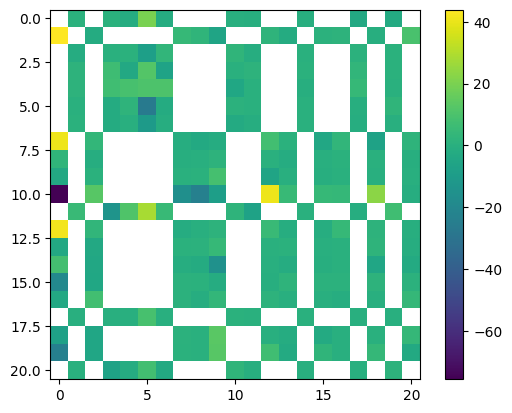

In [ ]:
plt.imshow(sim[0]); plt.colorbar()

# END OF MY ATTEMPT

# CKA across layers using ONLY weights of all layers

This calculates CKA across weights of layers. This is slightly different from the usual way it is run: usually, a test dataset is used and the CKA between the representations are calculated.

In [ ]:
!wget https://raw.githubusercontent.com/yuanli2333/CKA-Centered-Kernel-Alignment/master/CKA.py
from CKA import linear_CKA, kernel_CKA

--2023-05-06 18:11:04--  https://raw.githubusercontent.com/yuanli2333/CKA-Centered-Kernel-Alignment/master/CKA.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1559 (1.5K) [text/plain]
Saving to: ‘CKA.py.1’

CKA.py.1            100%[===================>]   1.52K  --.-KB/s    in 0s      

2023-05-06 18:11:04 (18.7 MB/s) - ‘CKA.py.1’ saved [1559/1559]



In [ ]:
names = []
cka_matrix = []

for i, m in enumerate(
    zip(
      models[0].module.named_children(), models[1].module.named_children()
    )
):
  if not isinstance(m[0][1], nn.Conv2d):
    continue
  assert m[0][0] == m[1][0]
  name = m[0][0]
  with torch.no_grad():
    weights1 = m[0][1].weight.numpy()
    weights2 = m[1][1].weight.numpy()

  weights1 = weights1.reshape(weights1.shape[0], -1)
  weights2 = weights2.reshape(weights2.shape[0], -1)

  print(weights1.shape, weights2.shape)

  assert not np.isnan(weights1).any()
  assert not np.isnan(weights2).any()

  cka_sim = linear_CKA(
      weights1.T, weights2.T
  )
  cka_matrix.append(cka_sim)

(24, 9) (24, 9)
(24, 216) (24, 216)
(24, 96) (24, 96)
(48, 216) (48, 216)
(48, 432) (48, 432)
(48, 192) (48, 192)
(96, 432) (96, 432)
(96, 864) (96, 864)
(96, 384) (96, 384)
(192, 864) (192, 864)
(192, 1728) (192, 1728)
(192, 768) (192, 768)
(384, 1728) (384, 1728)
(384, 3456) (384, 3456)
(384, 1536) (384, 1536)
(768, 3456) (768, 3456)
(768, 6912) (768, 6912)
(768, 3072) (768, 3072)
(1536, 12288) (1536, 12288)


In [ ]:
plt.imshow(cka_sim, origin='lower', cmap='magma'); plt.colorbar(); plt.show()

# CKA across layers using a test dataset

Get the data and simulation parameter file

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_IllustrisTNG.txt

--2023-05-06 15:43:44--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932160128 (3.7G) [application/octet-stream]
Saving to: ‘Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy’

Maps_Mtot_Nbody_Ill 100%[===================>]   3.66G  44.9MB/s    in 88s     

2023-05-06 15:45:13 (42.8 MB/s) - ‘Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy’ saved [3932160128/3932160128]

--2023-05-06 15:45:13--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_IllustrisTNG.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flat

In [ ]:
# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


# This class creates the dataset. Rotations and flippings are precompued and stored in memory
class make_dataset_multifield():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize the value of the cosmological & astrophysical parameters
        minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        # define the matrix containing the maps with rotations and flipings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This class creates the dataset. It will read the maps and store them in memory.
# The rotations and flipings are done when calling the data
class make_dataset_multifield2():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of simulations and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]

        # normalize params
        minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            print(data_c.shape, total_maps)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)

        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]

In [ ]:
# data parameters
fmaps      = ['/content/maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = '/content/params_Nbody_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 5   #number of maps per simulation

batch_size = 128
# lr         = 0.0003684461504422994
# wd         = 0.009957489933288342  #value of weight decay
# dr         = 0.4215669874309596    #dropout value for fully connected layers
# hidden     = 6      #this determines the number of channels in the CNNs; integer larger than 1
# epochs     = 100    #number of epochs to train the network

channels        = 1                #we only consider here 1 field
params          = [0,1,2,3,4,5]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict all these parameters.
g               = params           #g will contain the mean of the posterior
h               = [6+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

In [ ]:
fmaps2 = '/content/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

Shape of the maps: (15000, 256, 256)


In [ ]:
# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

Selected 5000 maps out of 15000


In [ ]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, 16, splits, fmaps_norm,  # 16 is batch_size. IMPORTANT: batch_size=1 gave error.
                                         rot_flip_in_mem=False, verbose=True)

# get the number of maps in the test set
num_maps = 0
for x,y in test_loader:
      num_maps += x.shape[0]
print('\nNumber of maps in the test set: %d'%num_maps)

# define the arrays containing the value of the parameters
params_true = np.zeros((num_maps,6), dtype=np.float32)
params_NN   = np.zeros((num_maps,6), dtype=np.float32)
errors_NN   = np.zeros((num_maps,6), dtype=np.float32)

# get test loss
test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
test_loss, points = 0.0, 0
model = models[1]
model.eval()
for x, y in test_loader:
    with torch.no_grad():
        bs    = x.shape[0]    #batch size
        x     = x.to(device)  #send data to device
        y     = y.to(device)  #send data to device
        p     = model(x)      #prediction for mean and variance
        y_NN  = p[:,:6]       #prediction for mean
        e_NN  = p[:,6:]       #prediction for error
        loss1 = torch.mean((y_NN[:,g] - y[:,g])**2,                     axis=0)
        loss2 = torch.mean(((y_NN[:,g] - y[:,g])**2 - e_NN[:,g]**2)**2, axis=0)
        test_loss1 += loss1*bs
        test_loss2 += loss2*bs

        # save results to their corresponding arrays
        params_true[points:points+x.shape[0]] = y.cpu().numpy()
        params_NN[points:points+x.shape[0]]   = y_NN.cpu().numpy()
        errors_NN[points:points+x.shape[0]]   = e_NN.cpu().numpy()
        points    += x.shape[0]
test_loss = torch.log(test_loss1/points) + torch.log(test_loss2/points)
test_loss = torch.mean(test_loss).item()
print('Test loss = %.3e\n'%test_loss)

Norm_error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Normalized Error Omega_m = %.3f'%Norm_error[0])
print('Normalized Error sigma_8 = %.3f'%Norm_error[1])
print('Normalized Error A_SN1   = %.3f'%Norm_error[2])
print('Normalized Error A_AGN1  = %.3f'%Norm_error[3])
print('Normalized Error A_SN2   = %.3f'%Norm_error[4])
print('Normalized Error A_AGN2  = %.3f\n'%Norm_error[5])

# de-normalize
minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
params_true = params_true*(maximum - minimum) + minimum
params_NN   = params_NN*(maximum - minimum) + minimum
errors_NN   = errors_NN*(maximum - minimum)

error = np.sqrt(np.mean((params_true - params_NN)**2, axis=0))
print('Error Omega_m = %.3f'%error[0])
print('Error sigma_8 = %.3f'%error[1])
print('Error A_SN1   = %.3f'%error[2])
print('Error A_AGN1  = %.3f'%error[3])
print('Error A_SN2   = %.3f'%error[4])
print('Error A_AGN2  = %.3f\n'%error[5])

mean_error = np.absolute(np.mean(errors_NN, axis=0))
print('Bayesian error Omega_m = %.3f'%mean_error[0])
print('Bayesian error sigma_8 = %.3f'%mean_error[1])
print('Bayesian error A_SN1   = %.3f'%mean_error[2])
print('Bayesian error A_AGN1  = %.3f'%mean_error[3])
print('Bayesian error A_SN2   = %.3f'%mean_error[4])
print('Bayesian error A_AGN2  = %.3f\n'%mean_error[5])

rel_error = np.sqrt(np.mean((params_true - params_NN)**2/params_true**2, axis=0))
print('Relative error Omega_m = %.3f'%rel_error[0])
print('Relative error sigma_8 = %.3f'%rel_error[1])
print('Relative error A_SN1   = %.3f'%rel_error[2])
print('Relative error A_AGN1  = %.3f'%rel_error[3])
print('Relative error A_SN2   = %.3f'%rel_error[4])
print('Relative error A_AGN2  = %.3f\n'%rel_error[5])

# save results to file
#dataset = np.zeros((num_maps,18), dtype=np.float32)
#dataset[:,:6]   = params_true
#dataset[:,6:12] = params_NN
#dataset[:,12:]  = errors_NN
#np.savetxt(fresults,  dataset)
#np.savetxt(fresults1, Norm_error)

CUDA Not Available
Found 1 channels
Reading data...
(5000, 256, 256) 5000
4.957e+09 < F(all|orig) < 2.880e+15
9.695 < F(all|resc)  < 15.459
-2.795 < F(all|norm) < 8.860

Number of maps in the test set: 250
Test loss = -9.714e+00

Normalized Error Omega_m = 0.015
Normalized Error sigma_8 = 0.033
Normalized Error A_SN1   = 0.402
Normalized Error A_AGN1  = 0.472
Normalized Error A_SN2   = 0.476
Normalized Error A_AGN2  = 0.467

Error Omega_m = 0.006
Error sigma_8 = 0.013
Error A_SN1   = 1.508
Error A_AGN1  = 1.771
Error A_SN2   = 0.714
Error A_AGN2  = 0.701

Bayesian error Omega_m = 0.009
Bayesian error sigma_8 = 0.018
Bayesian error A_SN1   = 0.012
Bayesian error A_AGN1  = 0.008
Bayesian error A_SN2   = 0.002
Bayesian error A_AGN2  = 0.008

Relative error Omega_m = 0.019
Relative error sigma_8 = 0.017
Relative error A_SN1   = 0.823
Relative error A_AGN1  = 0.746
Relative error A_SN2   = 0.511
Relative error A_AGN2  = 0.483



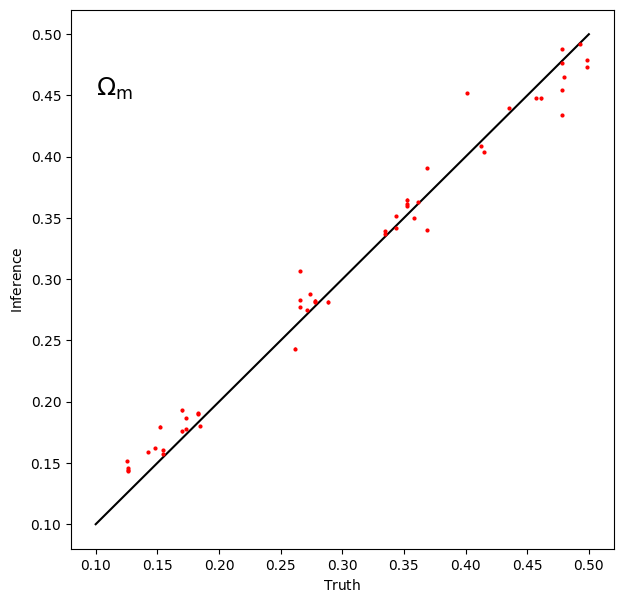

In [ ]:
import matplotlib.pyplot as plt
# select the first map of every simulation in the test set
indexes = np.arange(50)*splits

fig=plt.figure(figsize=(7,7))
plt.xlabel(r'${\rm Truth}$')
plt.ylabel(r'${\rm Inference}$')
plt.text(0.1, 0.45, r'$\Omega_{\rm m}$',fontsize=18)

plt.errorbar(params_true[indexes,0], params_NN[indexes,0], errors_NN[indexes,0],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
plt.plot([0.1,0.5], [0.1,0.5], color='k')

plt.show()

Perform CKA analysis. It requires minimal high-level code due to the `torch_cka` library.

In [ ]:
!pip install torch_cka

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch_cka import CKA
def perform_cka_layers(models, test_loader):
  layer_list = ['C01', 'C02', 'C03', 'C11', 'C12', 'C13', 'C21', 'C22', 'C23', 'C31', 'C32', 'C33', 'C41', 'C42', 'C43', 'C51', 'C52', 'C53']
  cka = CKA(models[0].module, models[1].module,
            model1_name="CNN_1",   # good idea to provide names to avoid confusion
            model2_name="CNN_2",
            model1_layers=layer_list, # List of layers to extract features from
            model2_layers=layer_list, # extracts all layer features by default
            # device='cuda'
  )

  cka.compare(test_loader) # secondary dataloader is optional

  results = cka.export()  # returns a dict that contains model names, layer names
                          # and the CKA matrix
  return results, cka

/usr/local/lib/python3.10/dist-packages/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 16/16 [02:07<00:00,  7.98s/it]


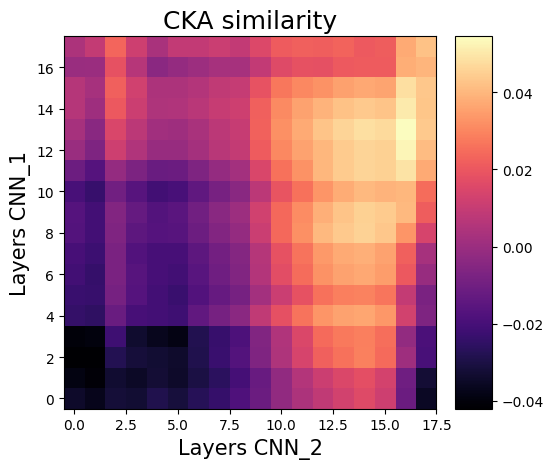

In [ ]:
results, cka = perform_cka_layers(models, test_loader)
cka.plot_results(save_path='/content/cka_matrix_camels.png', title='CKA similarity')

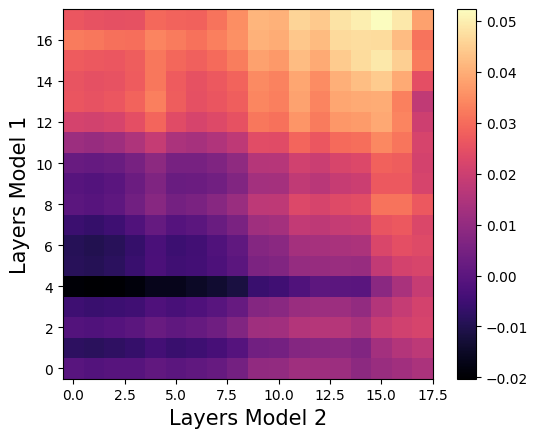

In [ ]:
plt.imshow(results['CKA'], cmap='magma', origin='lower'); plt.colorbar();
plt.xlabel(f"Layers Model 2", fontsize=15)
plt.ylabel(f"Layers Model 1", fontsize=15)
plt.show()

In [ ]:
models[0].module, models[1].module

model_o3_err(
  (C01): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C02): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C03): Conv2d(24, 24, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B01): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B02): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B03): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C11): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C12): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (C13): Conv2d(48, 48, kernel_size=(2, 2), stride=(2, 2), padding_mode=circular)
  (B11): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (B12): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_runnin

## My own trained CNNs

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from google.colab import drive
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os
import matplotlib.pyplot as plt

class model_a(nn.Module):
    def __init__(self, hidden):
        super(model_a, self).__init__()

        # input: 1x250x250 ---------------> output: hiddenx125x125
        self.C1 = nn.Conv2d(1,         hidden, kernel_size=4, stride=2, padding=1,
                            bias=True)
        self.B1 = nn.BatchNorm2d(hidden)
        # input: hiddenx125x125 ----------> output: 2*hiddenx62x62
        self.C2 = nn.Conv2d(hidden,   2*hidden, kernel_size=5, stride=2, padding=1,
                            bias=True)
        self.B2 = nn.BatchNorm2d(2*hidden)
        # input: 2*hiddenx62x62 --------> output: 4*hiddenx31x31
        self.C3 = nn.Conv2d(2*hidden, 4*hidden, kernel_size=4, stride=2, padding=1,
                            bias=True)
        self.B3 = nn.BatchNorm2d(4*hidden)
        # input: 4*hiddenx31x31 ----------> output: 8*hiddenx15x15
        self.C4 = nn.Conv2d(4*hidden, 8*hidden, kernel_size=5, stride=2, padding=1,
                            bias=True)
        self.B4 = nn.BatchNorm2d(8*hidden)
        # input: 8*hiddenx15x15 ----------> output: 16*hiddenx7x7
        self.C5 = nn.Conv2d(8*hidden, 16*hidden, kernel_size=5, stride=2, padding=1,
                            bias=True)
        self.B5 = nn.BatchNorm2d(16*hidden)
        # input: 16*hiddenx7x7 ----------> output: 100x3x3
        self.C6 = nn.Conv2d(16*hidden, 100, kernel_size=5, stride=2, padding=1,
                            bias=True)
        self.B6 = nn.BatchNorm2d(100)

        self.FC1  = nn.Linear(100*3*3, 6)

        self.dropout   = nn.Dropout(p=0.5)
        self.ReLU      = nn.ReLU()
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh      = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)


    def forward(self, image):
        x = self.LeakyReLU(self.C1(image))
        x = self.LeakyReLU(self.B2(self.C2(x)))
        x = self.LeakyReLU(self.B3(self.C3(x)))
        x = self.LeakyReLU(self.B4(self.C4(x)))
        x = self.LeakyReLU(self.B5(self.C5(x)))
        x = self.LeakyReLU(self.B6(self.C6(x)))
        x = x.view(image.shape[0],-1)
        x = self.FC1(x)

        y = torch.clone(x)
        y[:,2:4] = torch.square(x[:,2:4])

        return x

if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

hidden = 5
# now that architecture is defined above, use it
model1 = model_a(hidden)
model1.load_state_dict(torch.load('/content/weights.pt', map_location=torch.device('cpu')))
model2 = model_a(hidden)
model2.load_state_dict(torch.load('/content/weights_2.pt', map_location=torch.device('cpu')))

CUDA Not Available


<All keys matched successfully>

In [ ]:
# data parameters
fmaps      = ['maps_T.npy'] #tuple containing the maps with the different fields to consider
fmaps_norm = [None] #if you want to normalize the maps according to the properties of some data set, put that data set here (This is mostly used when training on IllustrisTNG and testing on SIMBA, or vicerversa)
fparams    = './params_Nbody_IllustrisTNG.txt'
seed       = 1   #random seed to split maps among training, validation and testing
splits     = 6   #number of maps per simulation

# training parameters
channels        = 1                #we only consider here 1 field
params          = [0,1]    #0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2). The code will be trained to predict only Omega_m and sigma8.
g               = params           #g will contain the mean of the posterior
h               = [2+i for i in g] #h will contain the variance of the posterior
rot_flip_in_mem = False            #whether rotations and flipings are kept in memory. True will make the code faster but consumes more RAM memory.

# optimizer parameters
beta1 = 0.5
beta2 = 0.999

# hyperparameters
batch_size = 4
lr         = 1e-3
wd         = 0.0005  #value of weight decay
dr         = 0.2    #dropout value for fully connected layers
hidden     = 5      #this determines the number of channels in the CNNs; integer larger than 1
epochs     = 100    #number of epochs to train the network

In [ ]:
!wget https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_IllustrisTNG.txt
!cp /content/drive/MyDrive/CAMELS/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy .

--2023-05-07 12:54:59--  https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_Nbody_IllustrisTNG.txt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48000 (47K) [text/plain]
Saving to: ‘params_Nbody_IllustrisTNG.txt.1’

params_Nbody_Illust 100%[===================>]  46.88K  --.-KB/s    in 0.06s   

2023-05-07 12:55:00 (729 KB/s) - ‘params_Nbody_IllustrisTNG.txt.1’ saved [48000/48000]



In [ ]:
fmaps2 = './Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'
maps  = np.load(fmaps2)
print('Shape of the maps:',maps.shape)

Shape of the maps: (15000, 256, 256)


In [ ]:
# define the array that will contain the indexes of the maps
indexes = np.zeros(1000*splits, dtype=np.int32)

# do a loop over all maps and choose the ones we want
count = 0
for i in range(15000):
    if i%15 in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of 15000'%count)

# save these maps to a new file
maps = maps[indexes]
np.save('maps_T.npy', maps)
del maps

Selected 6000 maps out of 15000


In [ ]:
# This routine returns the data loader need to train the network
def create_dataset_multifield(mode, seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                              rot_flip_in_mem=True, shuffle=True, verbose=False):

    # whether rotations and flippings are kept in memory
    if rot_flip_in_mem:
        data_set = make_dataset_multifield(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)
    else:
        data_set = make_dataset_multifield2(mode, seed, fmaps, fparams, splits, fmaps_norm, verbose)

    data_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader


# This class creates the dataset. Rotations and flippings are precompued and stored in memory
class make_dataset_multifield():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of sims and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params_maps = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params_maps[i*splits + j] = params_sims[i]

        # normalize the value of the cosmological & astrophysical parameters
        minimum     = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum     = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params_maps = (params_maps - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle sims not maps
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params_maps = params_maps[indexes]

        # define the matrix containing the maps with rotations and flipings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps*8, channels, height, width), dtype=np.float32)
        params   = np.zeros((size_maps*8, num_params),              dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:  print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:  print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
            else:
                # read data
                data_norm = np.load(fnorm)

                # rescale
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data_c = data_c[indexes]

            # do a loop over all rotations (each is 90 deg)
            counted_maps = 0
            for rot in [0,1,2,3]:
                data_rot = np.rot90(data_c, k=rot, axes=(1,2))

                data[counted_maps:counted_maps+size_maps,channel,:,:] = data_rot
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

                data[counted_maps:counted_maps+size_maps,channel,:,:] = \
                                                    np.flip(data_rot, axis=1)
                params[counted_maps:counted_maps+size_maps]           = params_maps
                counted_maps += size_maps

            if verbose:
                print('Channel %d contains %d maps'%(channel,counted_maps))
                print('%.3f < F < %.3f\n'%(np.min(data_c), np.max(data_c)))

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This class creates the dataset. It will read the maps and store them in memory.
# The rotations and flipings are done when calling the data
class make_dataset_multifield2():

    def __init__(self, mode, seed, fmaps, fparams, splits, fmaps_norm, verbose):

        # get the total number of simulations and maps
        params_sims = np.loadtxt(fparams) #simulations parameters, NOT maps parameters
        total_sims, total_maps, num_params = \
                params_sims.shape[0], params_sims.shape[0]*splits, params_sims.shape[1]
        params = np.zeros((total_maps, num_params), dtype=np.float32)
        for i in range(total_sims):
            for j in range(splits):
                params[i*splits + j] = params_sims[i]

        # normalize params
        minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
        maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
        params  = (params - minimum)/(maximum - minimum)

        # get the size and offset depending on the type of dataset
        if   mode=='train':  offset, size_sims = int(0.00*total_sims), int(0.90*total_sims)
        elif mode=='valid':  offset, size_sims = int(0.90*total_sims), int(0.05*total_sims)
        elif mode=='test':   offset, size_sims = int(0.95*total_sims), int(0.05*total_sims)
        elif mode=='all':    offset, size_sims = int(0.00*total_sims), int(1.00*total_sims)
        else:                raise Exception('Wrong name!')
        size_maps = size_sims*splits

        # randomly shuffle the simulations (not maps). Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        sim_numbers = np.arange(total_sims) #shuffle maps not rotations
        np.random.shuffle(sim_numbers)
        sim_numbers = sim_numbers[offset:offset+size_sims] #select indexes of mode

        # get the corresponding indexes of the maps associated to the sims
        indexes = np.zeros(size_maps, dtype=np.int32)
        count = 0
        for i in sim_numbers:
            for j in range(splits):
                indexes[count] = i*splits + j
                count += 1

        # keep only the value of the parameters of the considered maps
        params = params[indexes]

        # define the matrix containing the maps without rotations or flippings
        channels = len(fmaps)
        dumb     = np.load(fmaps[0])    #[number of maps, height, width]
        height, width = dumb.shape[1], dumb.shape[2];  del dumb
        data     = np.zeros((size_maps, channels, height, width), dtype=np.float32)

        # read the data
        print('Found %d channels\nReading data...'%channels)
        for channel, (fim, fnorm) in enumerate(zip(fmaps, fmaps_norm)):

            # read maps in the considered channel
            data_c = np.load(fim)
            if data_c.shape[0]!=total_maps:  raise Exception('sizes do not match')
            if verbose:
                print('%.3e < F(all|orig) < %.3e'%(np.min(data_c), np.max(data_c)))

            # rescale maps
            if fim.find('Mstar')!=-1:  data_c = np.log10(data_c + 1.0)
            else:                      data_c = np.log10(data_c)
            if verbose:
                print('%.3f < F(all|resc)  < %.3f'%(np.min(data_c), np.max(data_c)))

            # normalize maps
            if fnorm is None:
                mean,    std     = np.mean(data_c), np.std(data_c)
                minimum, maximum = np.min(data_c),  np.max(data_c)
            else:
                # read data
                data_norm     = np.load(fnorm)

                # rescale data
                if fnorm.find('Mstar')!=-1:  data_norm = np.log10(data_norm + 1.0)
                else:                        data_norm = np.log10(data_norm)

                # compute mean and std
                mean,    std     = np.mean(data_norm), np.std(data_norm)
                minimum, maximum = np.min(data_norm),  np.max(data_norm)
                del data_norm

            data_c = (data_c - mean)/std
            if verbose:  print('%.3f < F(all|norm) < %.3f'%(np.min(data_c), np.max(data_c)))

            # keep only the data of the chosen set
            data[:,channel,:,:] = data_c[indexes]

        self.size = data.shape[0]
        self.x    = torch.tensor(data,   dtype=torch.float32)
        self.y    = torch.tensor(params, dtype=torch.float32)
        del data, data_c

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        # choose a rotation angle (0-0, 1-90, 2-180, 3-270)
        # and whether do flipping or not
        rot  = np.random.randint(0,4)
        flip = np.random.randint(0,1)

        # rotate and flip the maps
        maps = torch.rot90(self.x[idx], k=rot, dims=[1,2])
        if flip==1:  maps = torch.flip(maps, dims=[1])

        return maps, self.y[idx]

# load test set
test_loader  = create_dataset_multifield('test', seed, fmaps, fparams, batch_size, splits, fmaps_norm,
                                         rot_flip_in_mem=False, verbose=True)

Found 1 channels
Reading data...
4.957e+09 < F(all|orig) < 2.880e+15
9.695 < F(all|resc)  < 15.459
-2.796 < F(all|norm) < 8.870


In [ ]:
!pip install torch_cka

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model1

model_a(
  (C1): Conv2d(1, 5, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (B1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C2): Conv2d(5, 10, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (B2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C3): Conv2d(10, 20, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (B3): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C4): Conv2d(20, 40, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (B4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C5): Conv2d(40, 80, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (B5): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (C6): Conv2d(80, 100, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (B6): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC1): Linear(in_fe

In [ ]:
from torch_cka import CKA
def perform_cka_layers(model1, model2, test_loader):
  layer_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'FC1']
  cka = CKA(model1, model2,
            model1_name="CNN_1",   # good idea to provide names to avoid confusion
            model2_name="CNN_2",
            model1_layers=layer_list, # List of layers to extract features from
            model2_layers=layer_list, # extracts all layer features by default
            # device='cuda'
  )

  cka.compare(test_loader) # secondary dataloader is optional

  results = cka.export()  # returns a dict that contains model names, layer names
                          # and the CKA matrix
  return results, cka

/usr/local/lib/python3.10/dist-packages/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 75/75 [00:03<00:00, 19.80it/s]


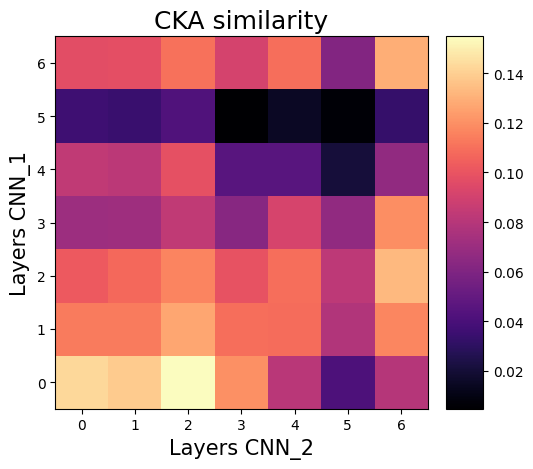

In [ ]:
results, cka = perform_cka_layers(model1, model2, test_loader)
cka.plot_results(save_path='/content/cka_matrix_camels.png', title='CKA similarity')

Old code

In [ ]:
# !wget https://raw.githubusercontent.com/yuanli2333/CKA-Centered-Kernel-Alignment/master/CKA.py
# from CKA import linear_CKA, kernel_CKA

In [ ]:
# names = []
# cka_matrix = []

# for m1 in model1.named_children():
#   for m2 in model2.named_children():
#     name1, name2 = m1[0], m2[0]; print(name1, name2)

#     with torch.no_grad():
#       weights1 = m1[1].weight.numpy()
#       weights2 = m2[1].weight.numpy()

#     weights1 = weights1.reshape(weights1.shape[0], -1)
#     weights2 = weights2.reshape(weights2.shape[0], -1)

#     print(weights1.shape, weights2.shape)

#     assert not np.isnan(weights1).any()
#     assert not np.isnan(weights2).any()

#     cka_sim = linear_CKA(
#         weights1.T, weights2.T
#     )
#     cka_matrix.append(cka_sim)


# cka_matrix_final = np.array(cka_matrix).reshape(int(len(cka_matrix)/2), int(len(cka_matrix)/2))
# plt.imshow(cka_matrix_final, origin='lower', cmap='magma'); plt.colorbar(); plt.show()